In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import tarfile
from pathlib import Path
import seaborn as sns
import shap
from torchvision import transforms as T

In [2]:
# Model architecture
class MobileNetMultiRegressor(nn.Module):
    def __init__(self, num_outputs=4):
        super(MobileNetMultiRegressor, self).__init__()
        # Initialize the model with pretrained weights
        self.model = models.mobilenet_v2(pretrained=True)

        # Replace the final layer with a regression head
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_outputs)

    def forward(self, x):
        return self.model(x)

# Initialize the model with 4 outputs
model = MobileNetMultiRegressor(num_outputs=4)

# Load the saved weights from your .pth file
model_path = '/content/best_model_regression.pth'
# Try loading the state dict directly into the underlying model
model.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


# Set the model to evaluation mode if you're using it for inference
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 61.7MB/s]


MobileNetMultiRegressor(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kern

In [3]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    elif archive_folder is not None and (Path(cache_dir) / archive_folder).exsists:
      return Path(cache_dir) / archive_folder
    else:
      return Path(cache_dir)

    return Path(file_path)

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'


  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None, target_columns=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.target_columns = target_columns if target_columns is not None else ['spherical', 'ill_spherical', 'bending', 'arm_position']


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        # Load the specified target columns instead of just 'ill'
        targets = self.df.iloc[idx][self.target_columns].values.astype(np.float32)
        targets = torch.tensor(targets)

        if self.transform:
            image = self.transform(image)

        return image, targets

In [4]:
# download datafrom sciebo
data_dir = download_file(url="https://osf.io/download/kexzt/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5",
                         file_name="blockies_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='blockies_datasets')

100%|██████████| 1.00G/1.00G [00:29<00:00, 37.0MB/s]
/tmp/ipython-input-3849801842.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=cache_dir)


File downloaded to: /content/data/blockies_datasets.tar.gz
File extracted to: /content/data


In [5]:
import torch
from torchvision import transforms
from PIL import Image
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Define paths and settings
image_dir = Path("/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_normal/train")
device = torch.device("cpu")  # or "cuda" if GPU is available

# Define the image transform (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8068, 0.7830, 0.8005], std=[0.1093, 0.1136, 0.1029])
])

# Define output names (targets predicted by model)
output_names = ['spherical', 'ill_spherical', 'bending', 'arm_position']

# Collect image file paths
image_paths = sorted([
    p for p in image_dir.glob("*.png")
    if "mask" not in p.name.lower()
])
# Store results
results = []

# Predict for each image
model.eval()
model = model.to(device)

for img_path in tqdm(image_paths, desc="Predicting"):
    try:
        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)  # (1, 3, 224, 224)

        # Inference
        with torch.no_grad():
            preds = model(input_tensor)[0].cpu().numpy()  # shape: (4,)

        # Save result with filename
        result = {'filename': img_path.name}
        result.update(dict(zip(output_names, preds)))
        results.append(result)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Convert to DataFrame
df_normal_train_pred = pd.DataFrame(results)
print(df_normal_train_pred.head())




Predicting:   0%|          | 103/40000 [00:05<35:31, 18.72it/s]


KeyboardInterrupt: 

In [8]:
import pandas as pd
from pathlib import Path

# Path to the directory and parameters.jsonl
jsonl_path = Path("/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_normal/train/parameters.jsonl")

# Define target columns
target_columns = ['spherical', 'ill_spherical', 'bending', 'arm_position','ill','id']

# Load JSONL file
df_normal_train = pd.read_json(jsonl_path, lines=True)

# Print only the target columns
print(df_normal_train[target_columns])

       spherical  ill_spherical   bending  arm_position  ill  \
0       0.961125       1.041479  0.167486      0.464903    0   
1       1.132610       0.886779  0.125461      0.651250    1   
2       0.000280       0.335922  0.270202      0.604280    1   
3       0.999968       0.751764  0.088057      0.040346    0   
4       0.078524       0.434719  0.174206      0.558846    0   
...          ...            ...       ...           ...  ...   
39995   1.149467       0.513274  0.316350      0.473994    1   
39996   0.986871       0.523303  0.313423      0.500518    0   
39997   0.922204       0.448189  0.195888      0.352751    0   
39998   0.996810       0.512011  0.312570      0.443521    0   
39999   0.553803       1.159036  0.310657      0.450180    1   

                                         id  
0      cf4361b2-e7e1-4310-86c4-4e6fa9b2203c  
1      e2efcaf7-301e-4554-a7d4-458d5ee58186  
2      4a114b6c-7c19-493a-8235-f081a44bace4  
3      368edd55-fa31-417f-a484-66f05b77968e  
4

In [ ]:
import pandas as pd

# Remove .png and rename column
df_normal_train_pred["id"] = df_normal_train_pred["filename"].str.replace(".png", "", regex=False)
df_normal_train_pred = df_normal_train_pred.drop(columns=["filename"])

# Merge with second dataframe based on 'id'
df_normal_train_pred_merged = df_normal_train_pred.merge(df_normal_train[["id", "ill"]], on="id", how="left")

print(df_normal_train_pred_merged.head())

   spherical  ill_spherical   bending  arm_position  \
0   0.116306       0.397688  0.176160      0.413244   
1   0.683238       0.609745  0.220931      0.422136   
2   0.613870       0.498450  0.195655      0.518936   
3   0.677015       0.513941  0.171270      0.469666   
4   0.703036       0.631843  0.189489      0.452130   

                                     id  ill  
0  0001056c-7b9c-418c-aede-5deeebddaeb8    1  
1  0001ece1-8aaf-4017-9459-c77913ad7fe7    1  
2  00022717-fc41-49d2-9714-acbcd0462dd6    0  
3  000453d4-1285-429a-8b4d-acf9dd94bbfb    0  
4  000509a2-44d9-4436-ab7a-fa9950316c50    0  


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

feature_columns = ['spherical', 'ill_spherical', 'bending', 'arm_position']
X = df_normal_train_pred_merged[feature_columns].values
y = df_normal_train_pred_merged['ill'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy: 0.66975
Random Forest Accuracy: 0.68675


In [11]:
import torch
from torchvision import transforms
from PIL import Image
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Define paths and settings
image_dir = Path("/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_variation/test")
device = torch.device("cpu")  # or "cuda" if GPU is available

# Define the image transform (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8068, 0.7830, 0.8005], std=[0.1093, 0.1136, 0.1029])
])

# Define output names (targets predicted by model)
output_names = ['spherical', 'ill_spherical', 'bending', 'arm_position']

# Collect image file paths
image_paths = sorted([
    p for p in image_dir.glob("*.png")
    if "mask" not in p.name.lower()
])
# Store results
results = []

# Predict for each image
model.eval()
model = model.to(device)

for img_path in tqdm(image_paths, desc="Predicting"):
    try:
        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)  # (1, 3, 224, 224)

        # Inference
        with torch.no_grad():
            preds = model(input_tensor)[0].cpu().numpy()  # shape: (4,)

        # Save result with filename
        result = {'filename': img_path.name}
        result.update(dict(zip(output_names, preds)))
        results.append(result)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Convert to DataFrame
df_variation_test_pred = pd.DataFrame(results)

# Corrected line: Use df_variation_test_pred instead of df_normal_train_pred
df_variation_test_pred["id"] = df_variation_test_pred["filename"].str.replace(".png", "", regex=False)
df_variation_test_pred = df_variation_test_pred.drop(columns=["filename"])
print(df_variation_test_pred.head())

Predicting: 100%|██████████| 3000/3000 [01:49<00:00, 27.33it/s]

   spherical  ill_spherical   bending  arm_position  \
0   0.596664       0.517282  0.218148      0.393396   
1   0.633909       0.419077  0.226227      0.423046   
2   0.698435       0.689792  0.176265      0.483310   
3   0.644638       0.502506  0.223155      0.401757   
4   0.572596       0.582833  0.200226      0.441646   

                                     id  
0  00003317-12bc-418b-9b37-9bc70e06fc2e  
1  000d9e54-6848-49f5-8b60-d98ae58f496b  
2  000eff83-2e37-4f63-9ddd-f0c5870e700d  
3  0017a7da-f3f0-4b1c-8600-800319e3e847  
4  001bb69b-a5a6-49ac-a77b-9cb3d385b083  


In [12]:
import pandas as pd
from pathlib import Path

# Path to the directory and parameters.jsonl
jsonl_path = Path("/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_variation/test/parameters.jsonl")

# Define target columns
target_columns = ['spherical', 'ill_spherical', 'bending', 'arm_position','ill','id']

# Load JSONL file
df_variation_test = pd.read_json(jsonl_path, lines=True)

# Print only the target columns
print(df_variation_test[target_columns])

      spherical  ill_spherical   bending  arm_position  ill  \
0      0.058385       0.726311  0.132758      0.509228    0   
1      0.221904       0.359228  0.078521      0.504040    0   
2      0.466874       0.401758  0.151236      0.494414    0   
3      0.494998       0.048708  0.145815      0.191810    0   
4      1.119224       0.435623  0.161273      0.603745    1   
...         ...            ...       ...           ...  ...   
2995   0.001709       0.617154  0.261107      0.396843    1   
2996   0.999805       0.413563  0.174272      0.189993    0   
2997   0.998775       0.343383  0.032666      0.506470    1   
2998   0.989610       1.048802  0.096102      0.337538    0   
2999   0.011264       0.701526  0.154577      0.639980    1   

                                        id  
0     9ff5aed1-3e27-4e63-bba9-35473822c1df  
1     a7df8117-3e13-4756-be3e-532c4a37dac1  
2     c29b27a4-53a6-42eb-9b48-4cca5ad08df9  
3     a2609b43-1f1d-4750-afbc-4ced511d332e  
4     04dfb08a-c92

In [15]:
import joblib

# Load saved Random Forest model
rf = joblib.load("/content/random_forest_model.joblib")

In [17]:
# Merge predictions with ground truth based on 'id'
df_variation_test_merged = df_variation_test_pred.merge(
    df_variation_test[target_columns],
    on="id",
    how="left",
    suffixes=("_pred", "_true")
)

feature_columns = ['spherical_pred', 'ill_spherical_pred', 'bending_pred', 'arm_position_pred']

# Extract features for prediction
X_test_new = df_variation_test_merged[feature_columns].values
y_true = df_variation_test_merged['ill'].values  # ground truth

# Predict using trained models
#y_pred_lr = lr.predict(X_test_new)
y_pred_rf = rf.predict(X_test_new)

# Print accuracy and classification reports
from sklearn.metrics import accuracy_score

#print("Logistic Regression Accuracy on Variation Test Set:", accuracy_score(y_true, y_pred_lr))
print("\nRandom Forest Accuracy on Variation Test Set:", accuracy_score(y_true, y_pred_rf))


Random Forest Accuracy on Variation Test Set: 0.6186666666666667


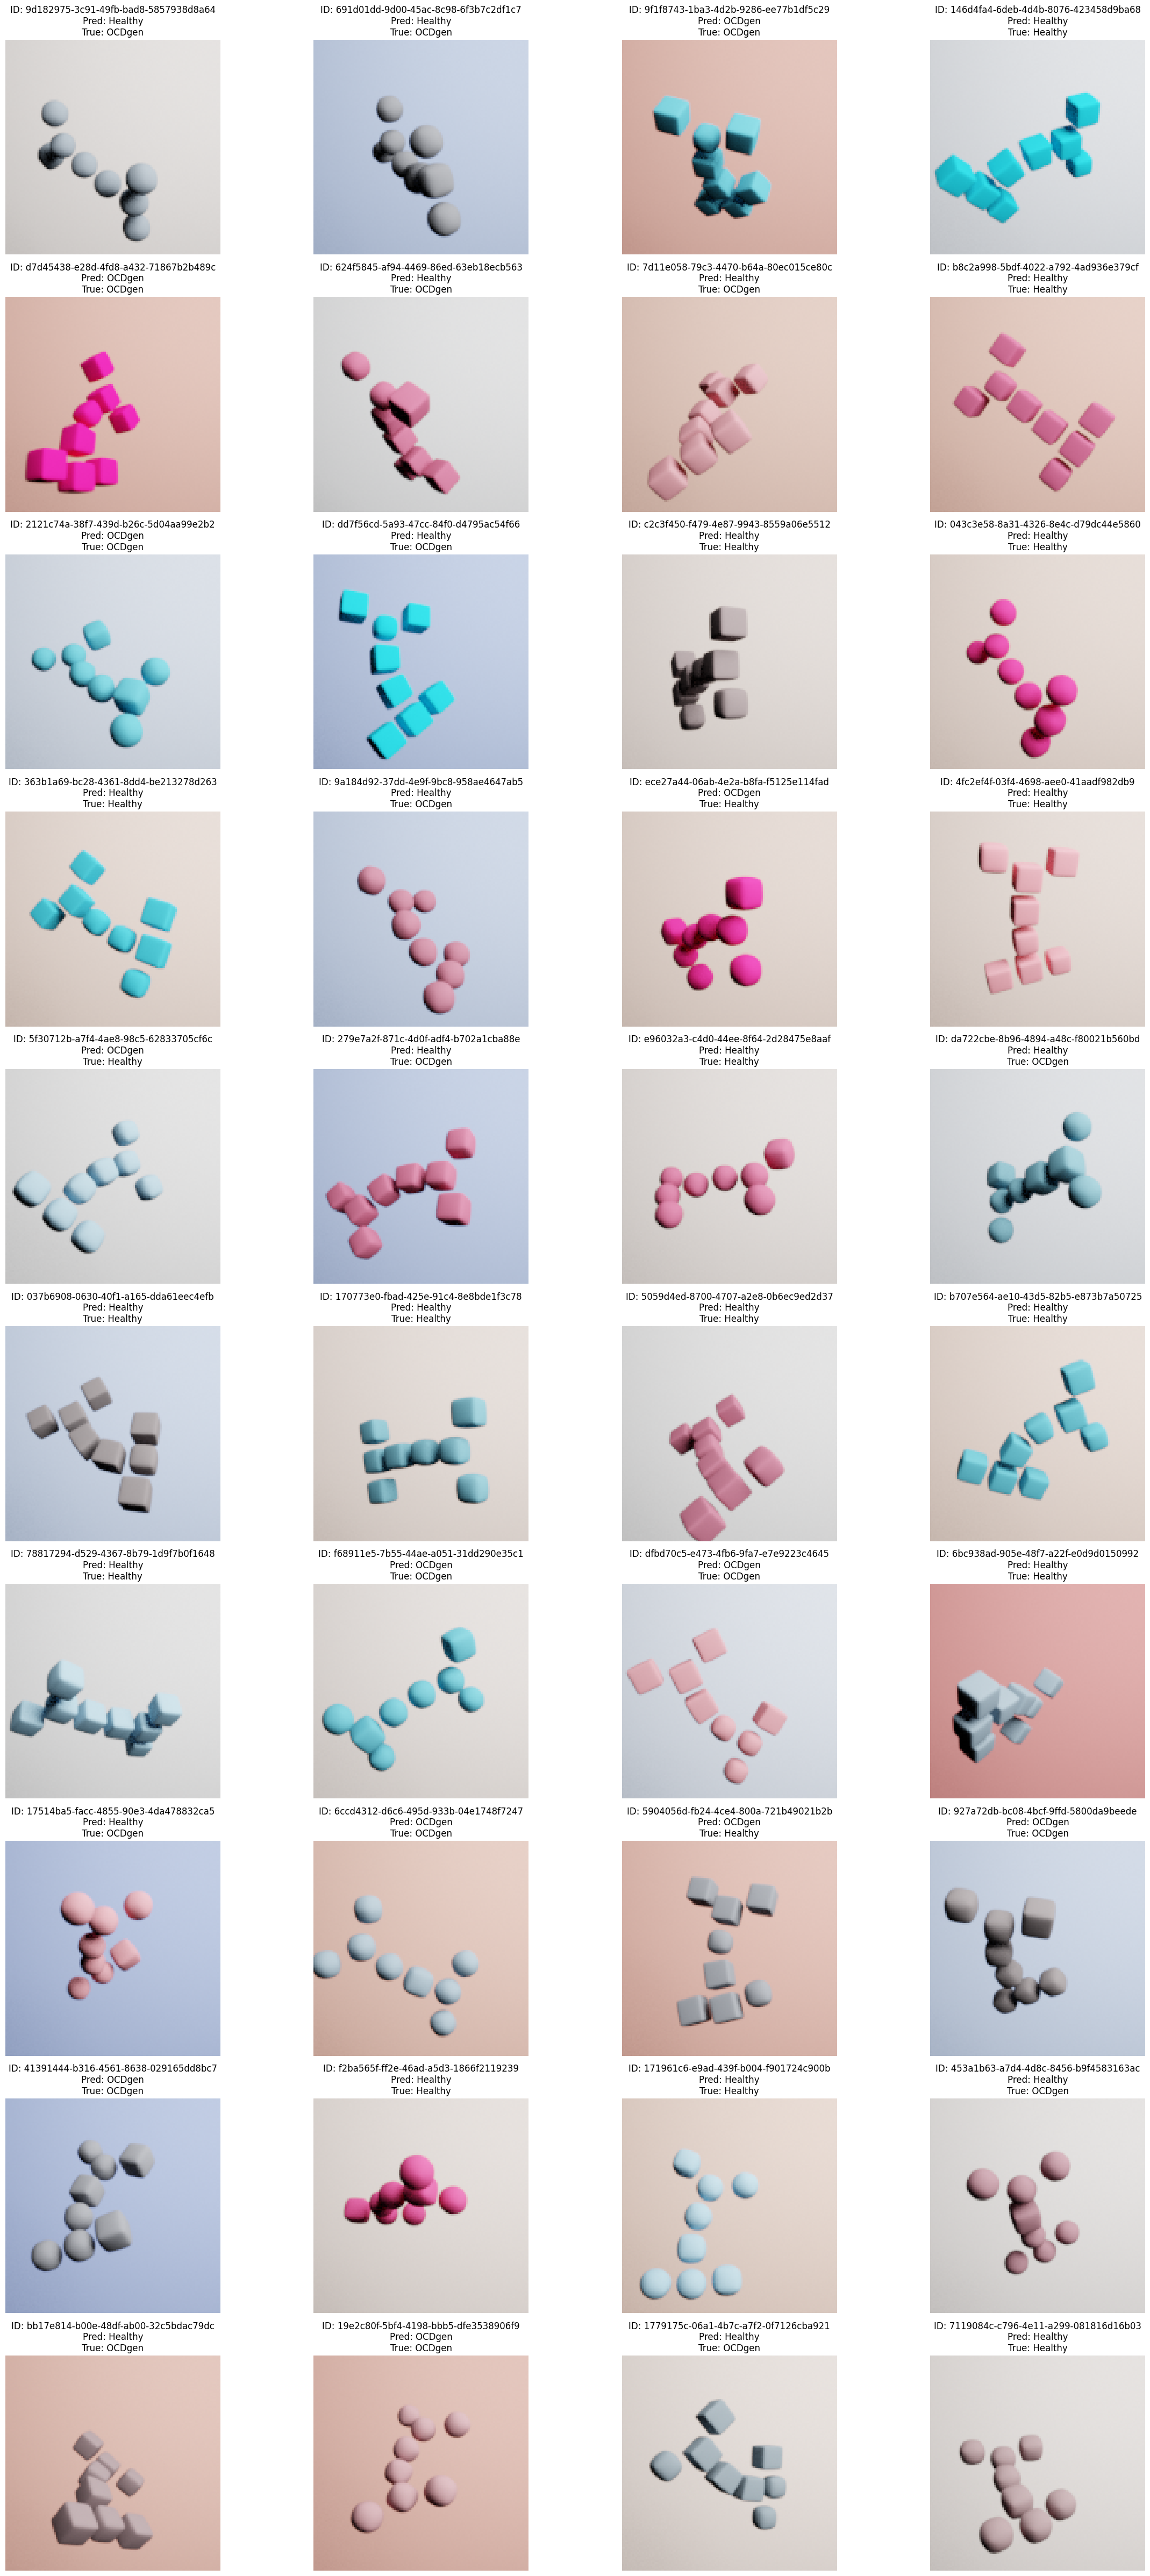

In [18]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Map numeric labels to text
label_map = {1: "OCDgen", 0: "Healthy"}

# Add the RF predictions and map to names
df_variation_test_merged['rf_pred_label'] = [label_map[p] for p in y_pred_rf]
df_variation_test_merged['true_label'] = [label_map[t] for t in df_variation_test_merged['ill']]

# Path to images
image_dir = Path("/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_variation/test")

# Select the first 40 samples randomly
df_sample = df_variation_test_merged.sample(40, random_state=42)

# Larger figure for bigger images
plt.figure(figsize=(24, 48))  # Increased size for better visibility

for i, row in enumerate(df_sample.itertuples(), start=1):
    img_path = image_dir / f"{row.id}.png"
    try:
        img = Image.open(img_path).convert("RGB")
        plt.subplot(10, 4, i)  # 10 rows × 4 cols = 40 images
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"ID: {row.id}\nPred: {row.rf_pred_label}\nTrue: {row.true_label}",
            fontsize=12
        )
    except FileNotFoundError:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()

In [19]:
print(df_sample)

      spherical_pred  ill_spherical_pred  bending_pred  arm_position_pred  \
1801        0.673856            0.604605      0.161534           0.421692   
1190        0.678398            0.526363      0.188551           0.350779   
1817        0.087328            0.579049      0.194585           0.411321   
251         0.075706            0.503422      0.168712           0.384340   
2505        0.074135            0.556471      0.197448           0.347673   
1117        0.414022            0.476108      0.174425           0.450624   
1411        0.200809            0.526551      0.225712           0.319584   
2113        0.065047            0.427895      0.171690           0.459742   
408         0.646621            0.495690      0.210121           0.444326   
2579        0.089795            0.488322      0.178134           0.365540   
2254        0.226905            0.491983      0.226225           0.430851   
52          0.627841            0.536903      0.165373           0.389808   

In [20]:
import shap
import matplotlib.pyplot as plt
# Create TreeSHAP explainer
explainer = shap.TreeExplainer(rf)
# Compute SHAP values on your variation test set
shap_values = explainer.shap_values(X_test_new)


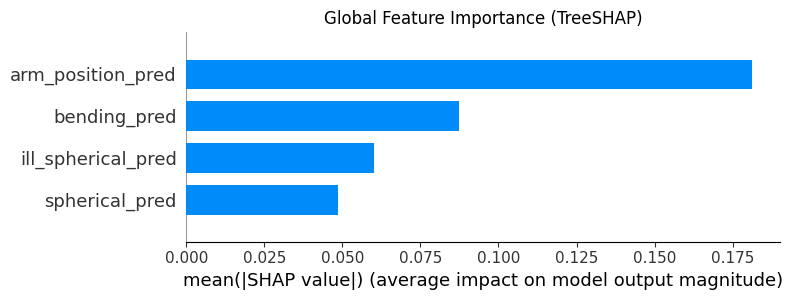

In [21]:
# Feature names for plots
feature_names = ['spherical_pred', 'ill_spherical_pred', 'bending_pred', 'arm_position_pred']

# Global SHAP importance bar plot
plt.title("Global Feature Importance (TreeSHAP)")
shap.summary_plot(shap_values[:, :, 1], X_test_new, feature_names=feature_names, plot_type="bar")

In [22]:
shap_values[1]


array([[-0.11791866,  0.11791866],
       [-0.07405891,  0.07405891],
       [-0.24825225,  0.24825225],
       [ 0.11437816, -0.11437816]])

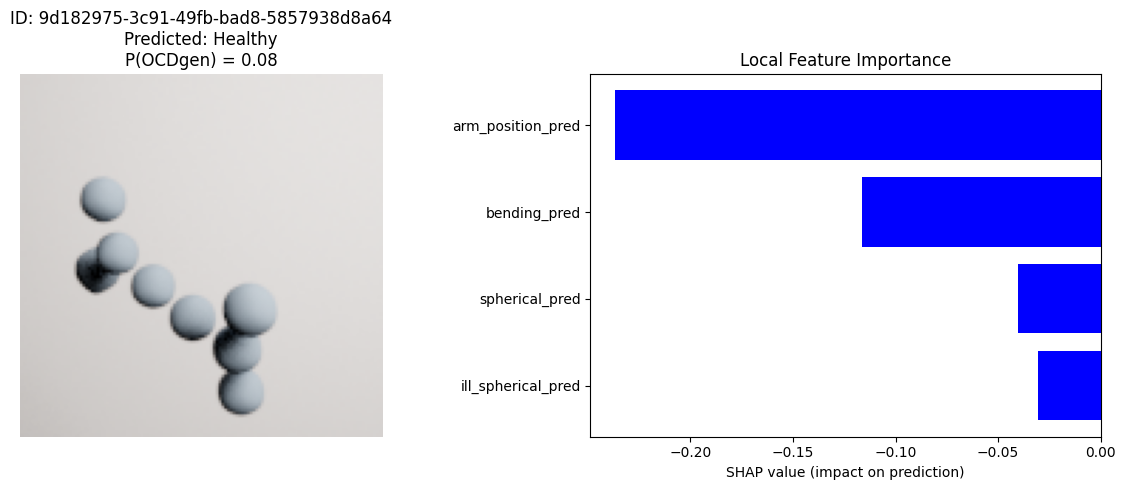

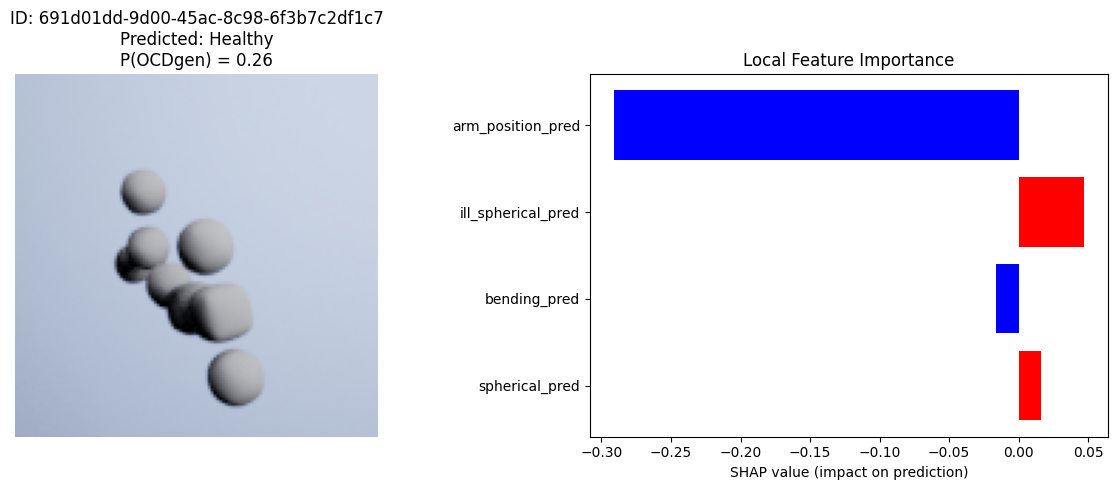

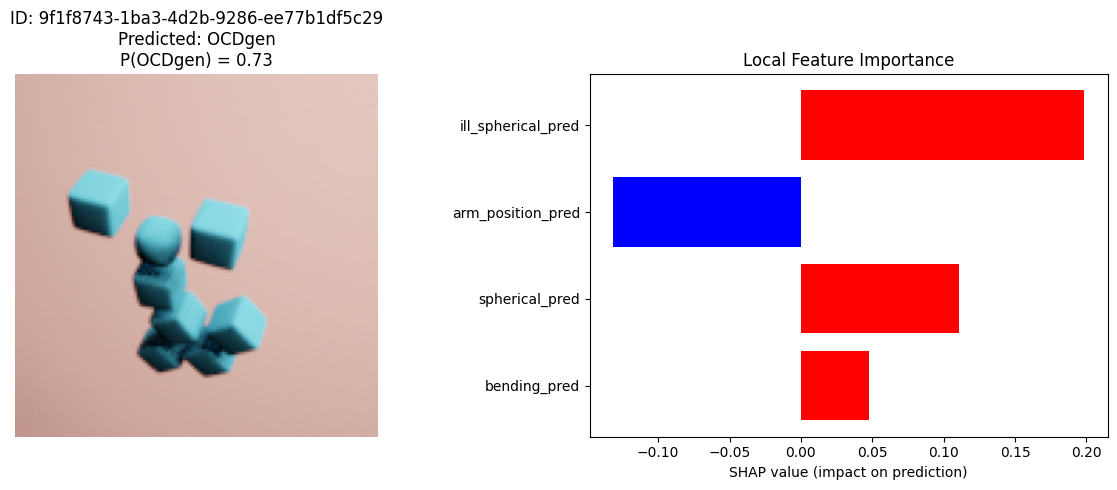

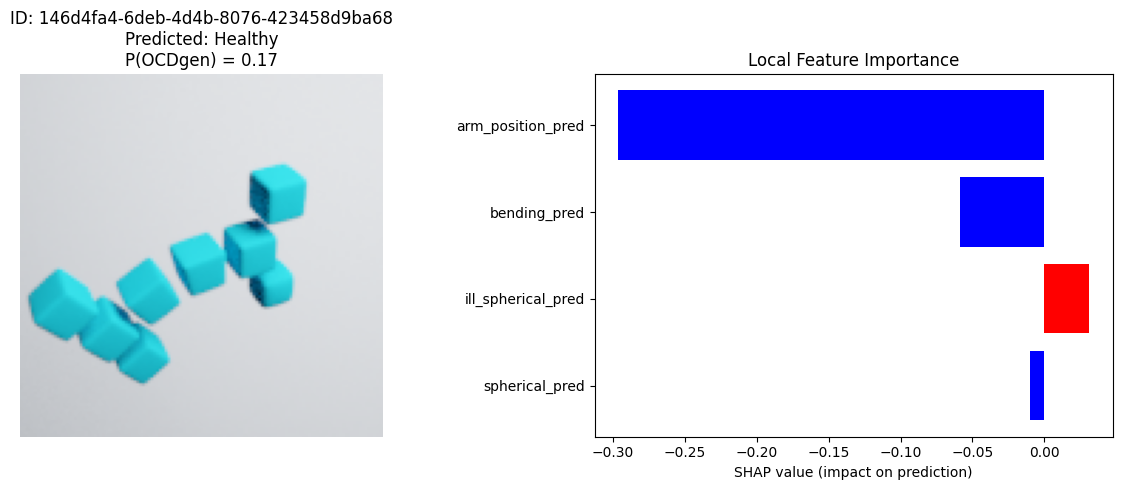

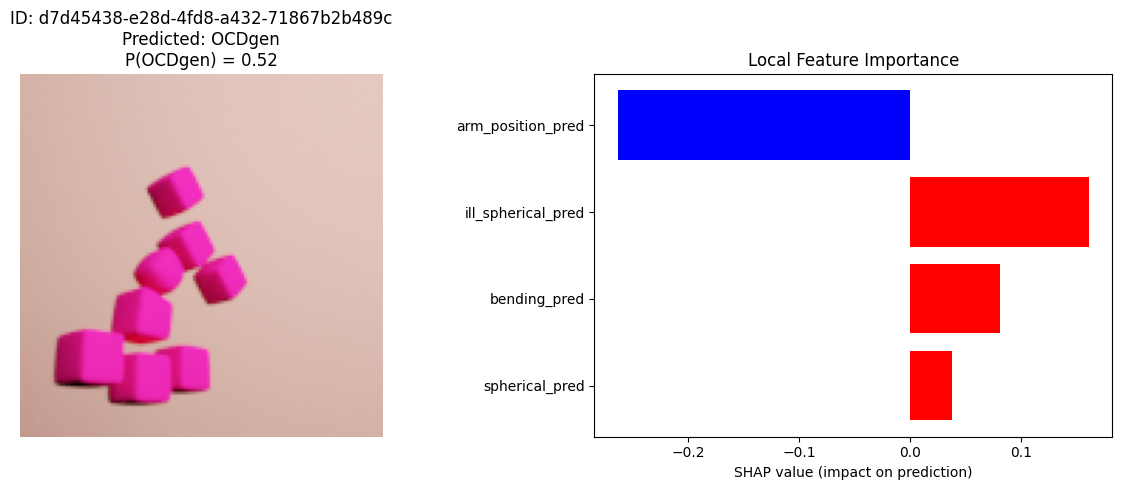

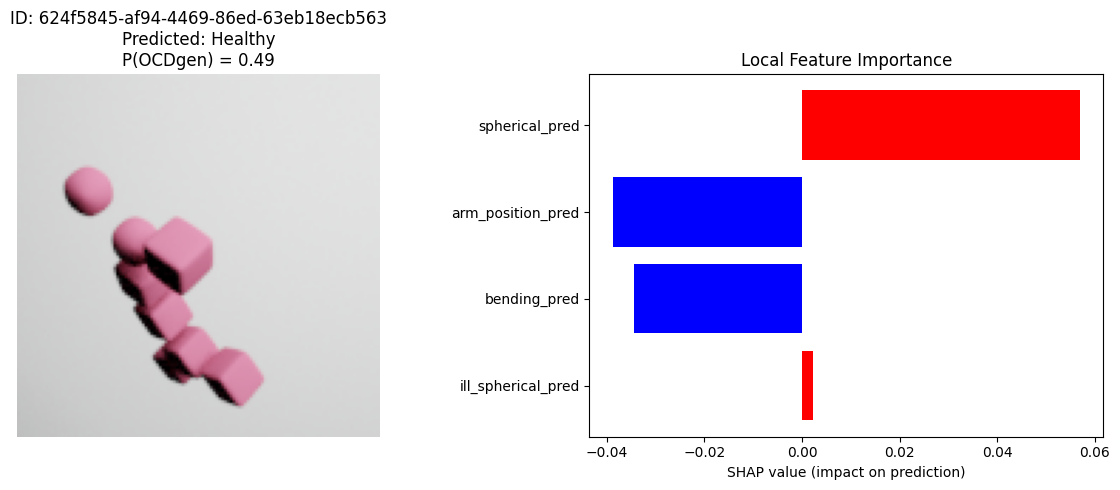

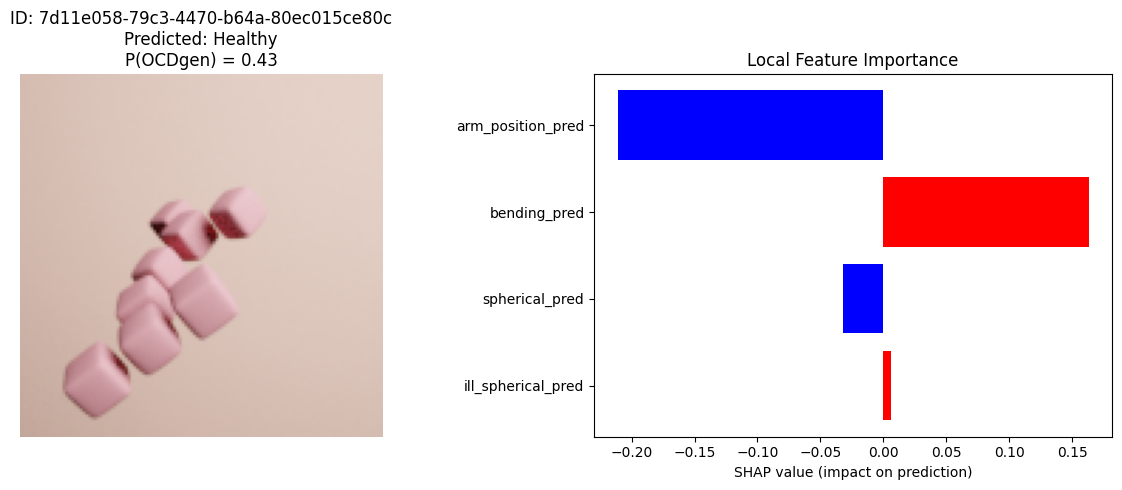

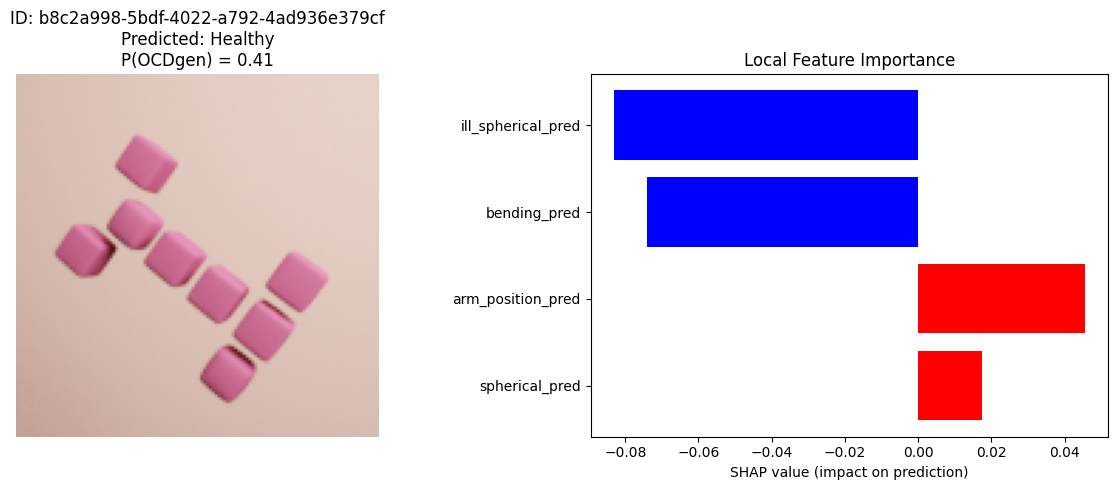

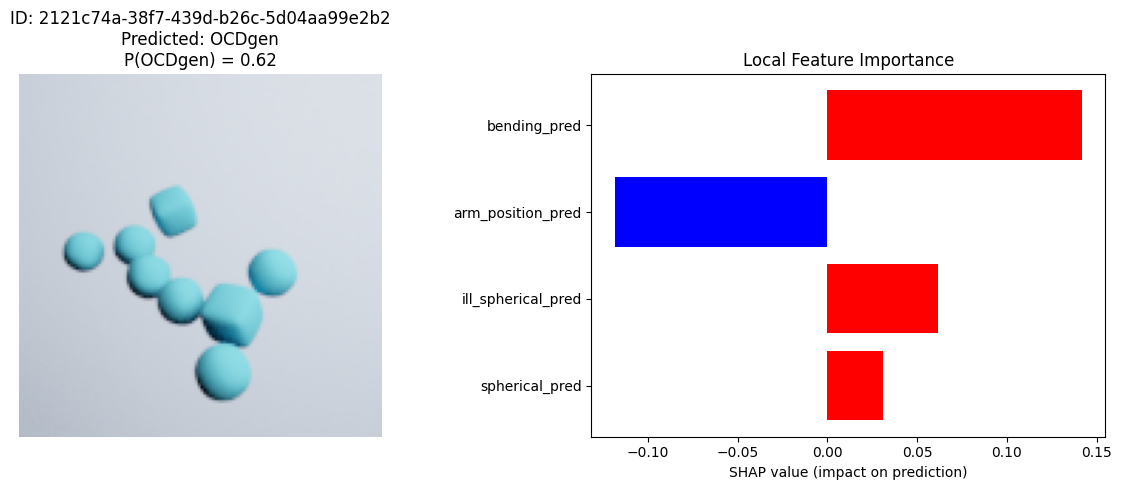

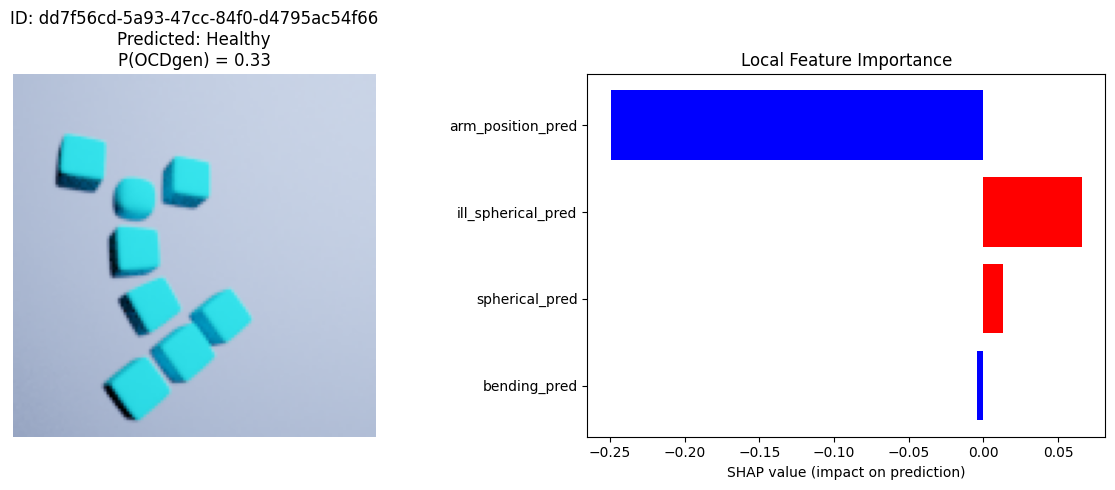

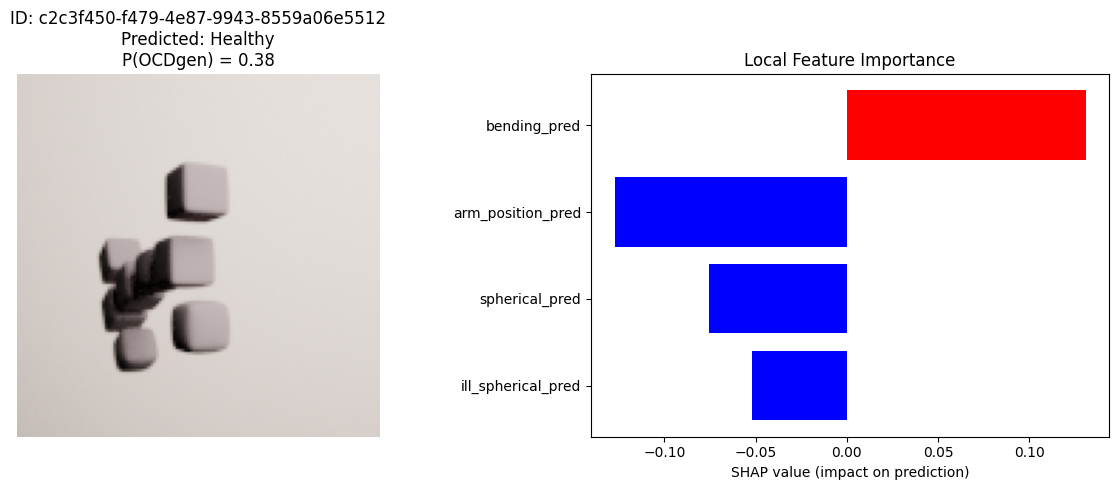

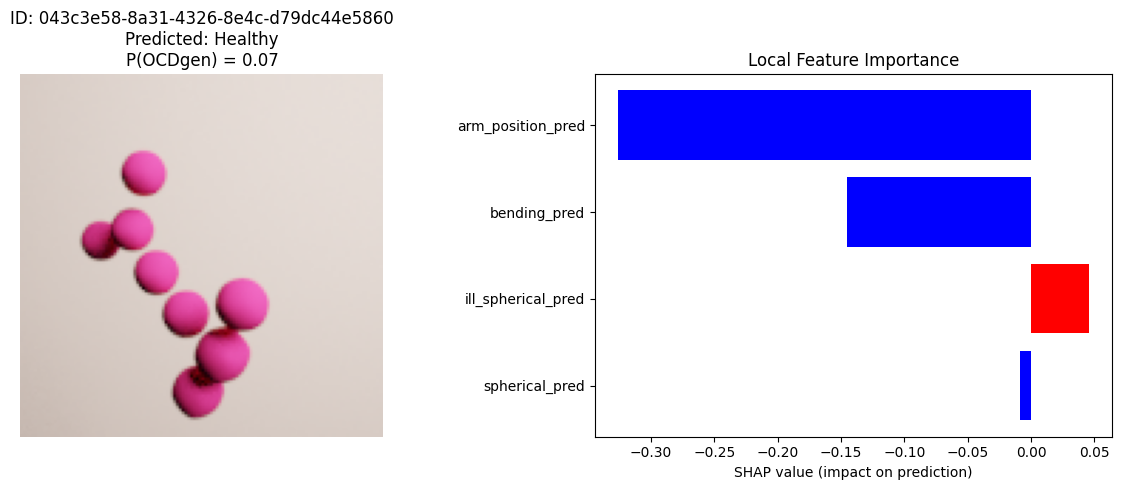

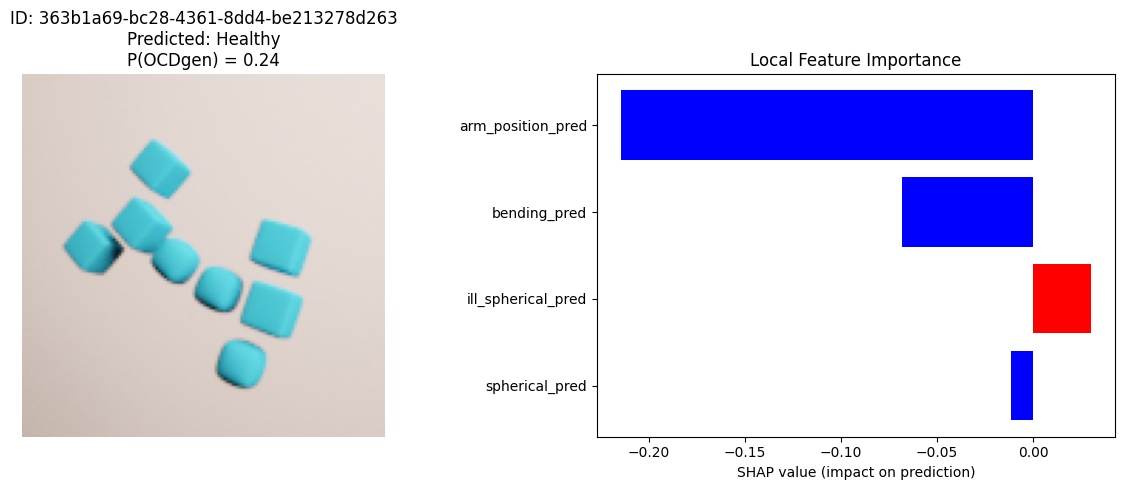

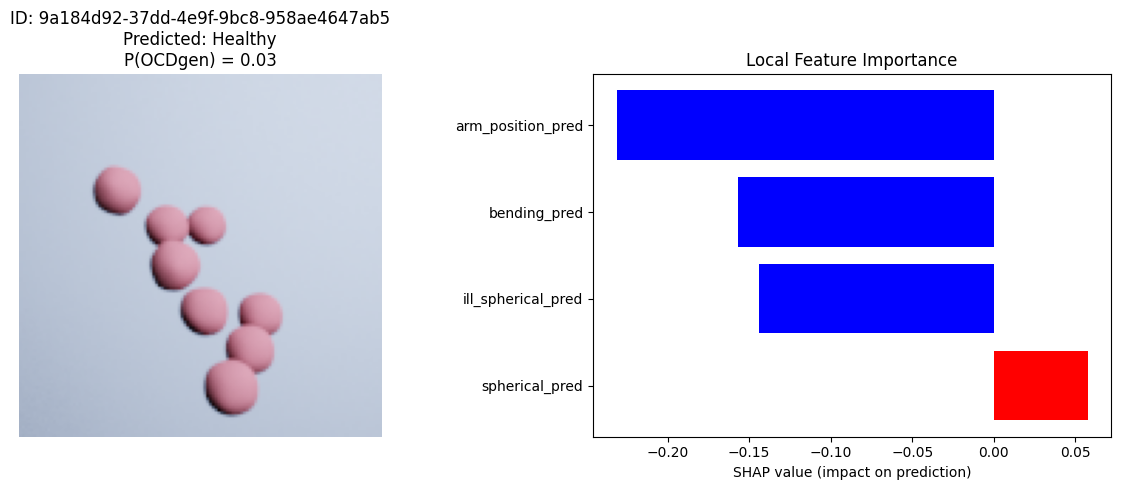

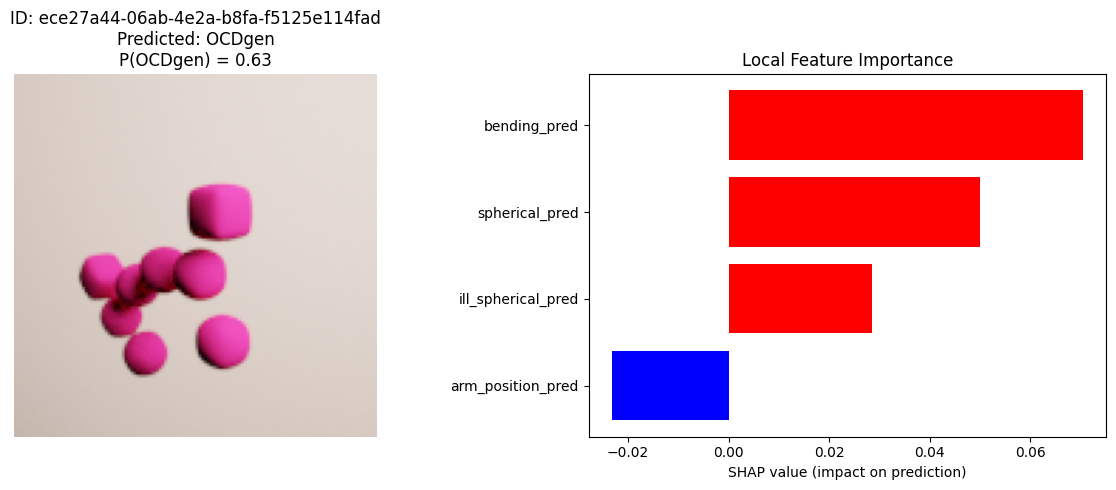

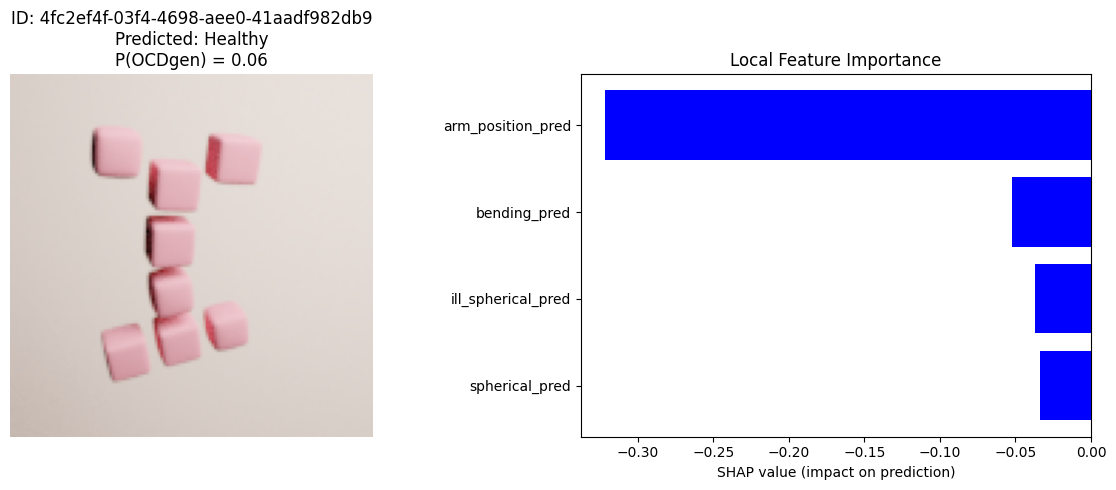

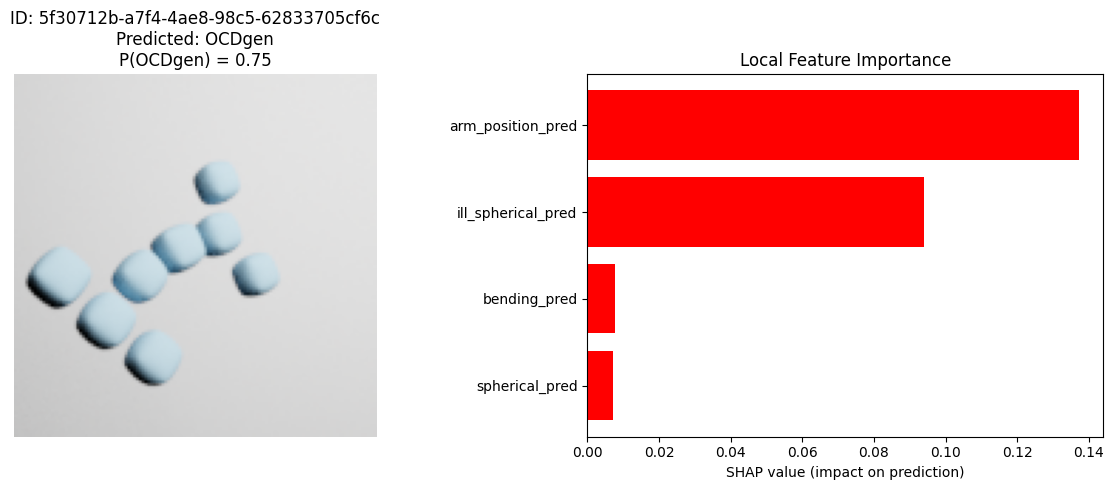

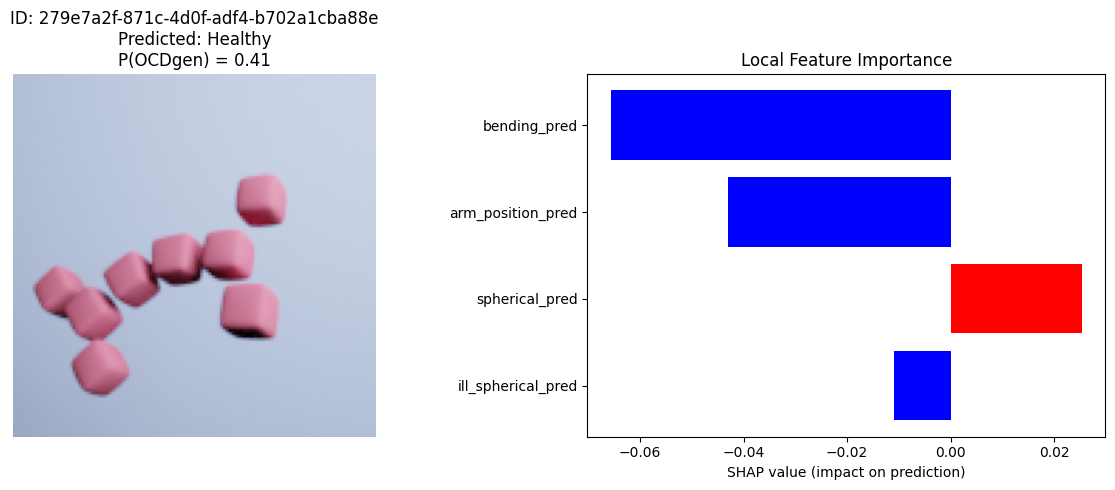

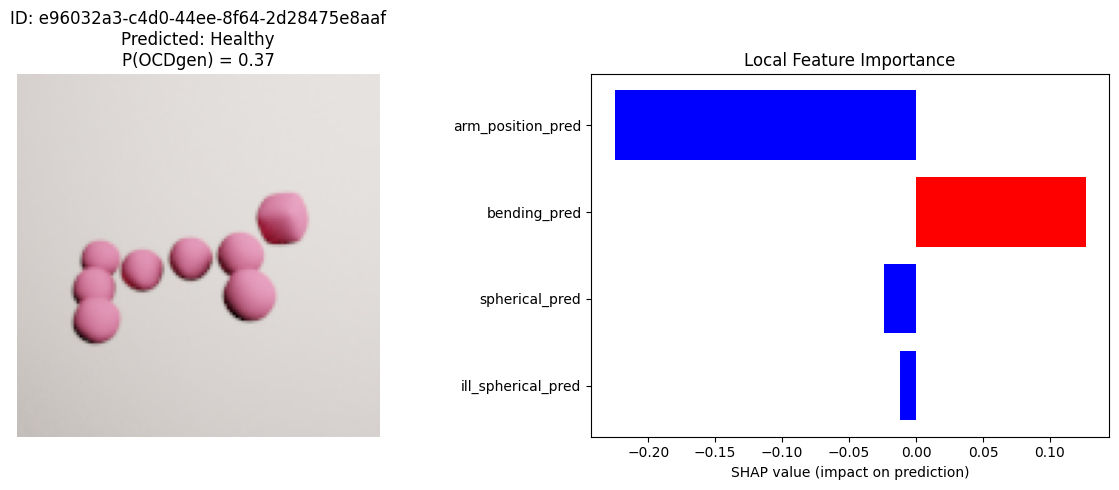

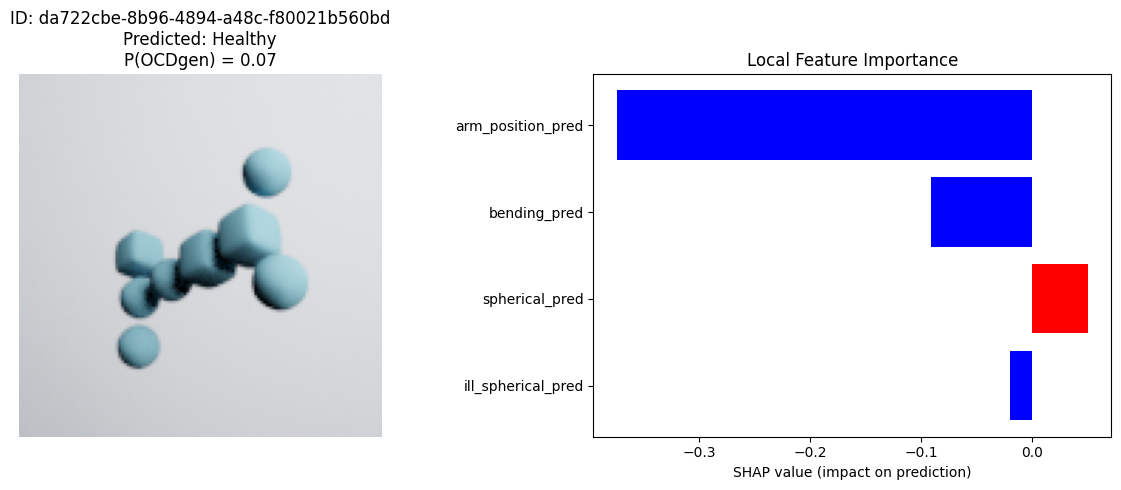

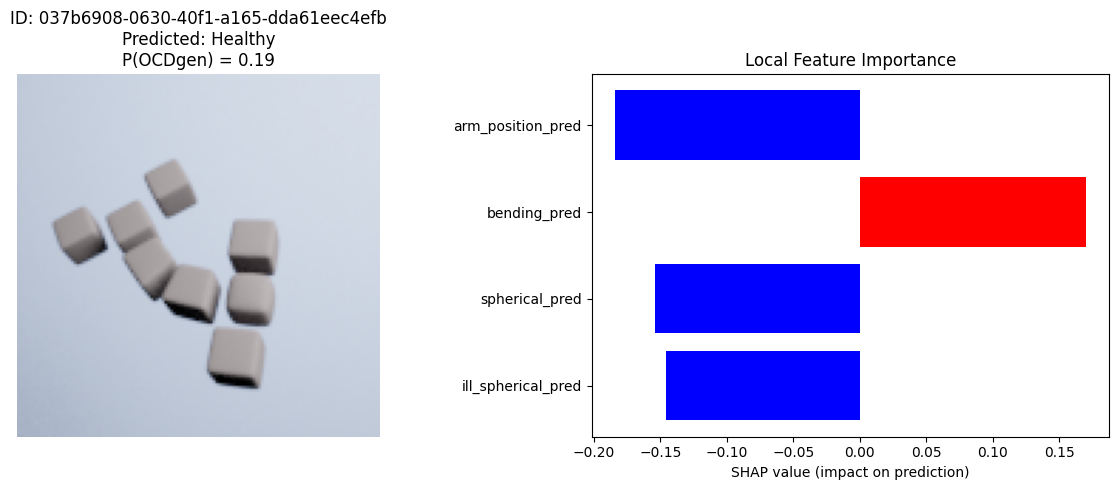

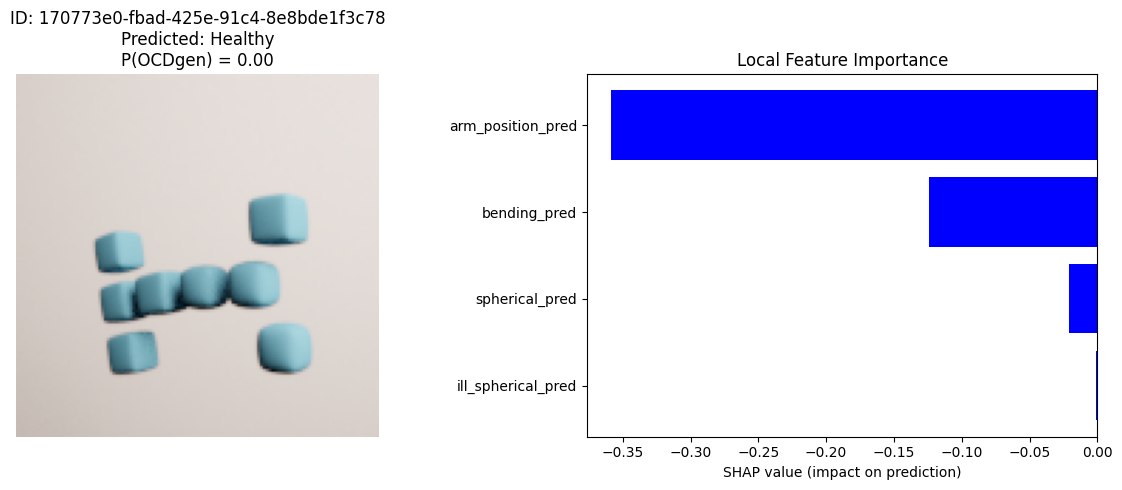

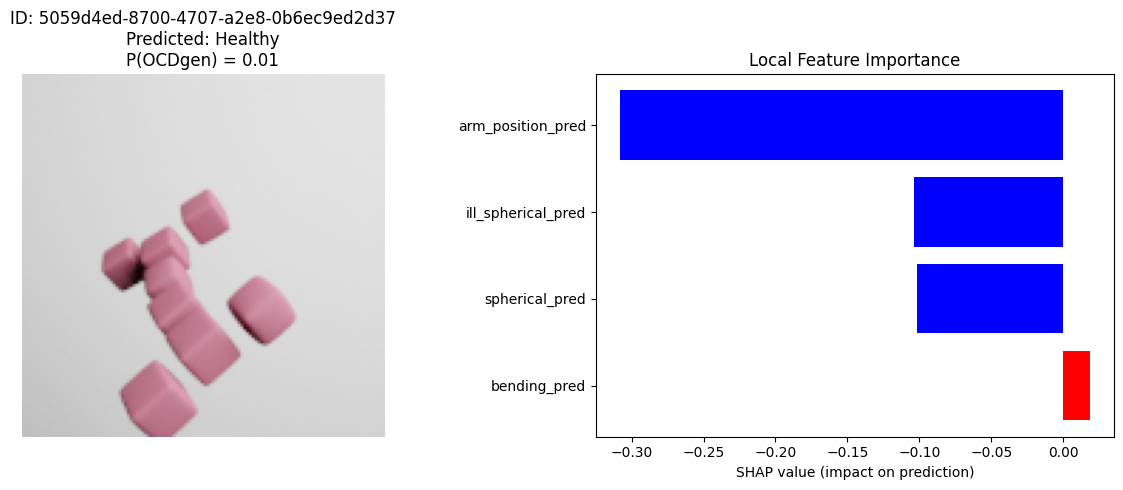

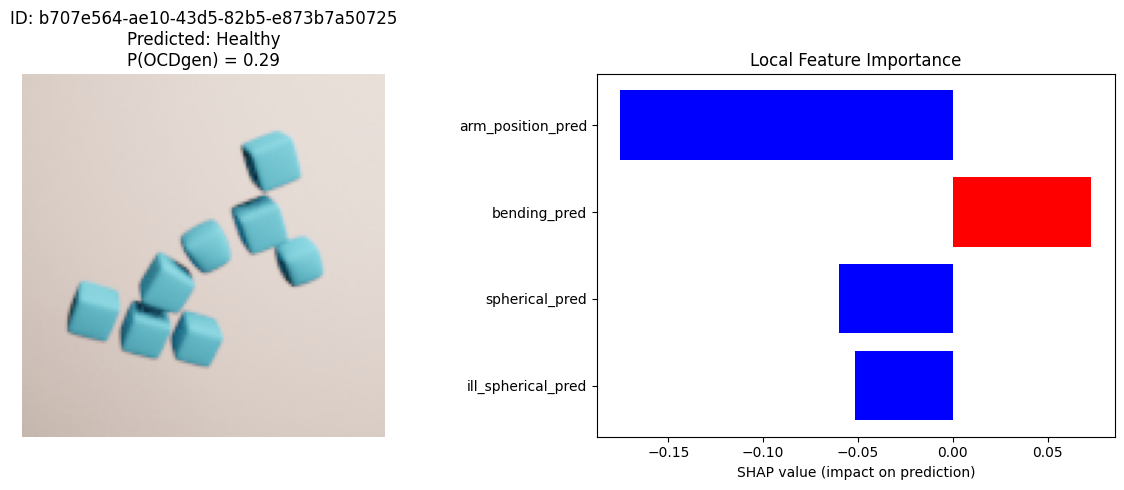

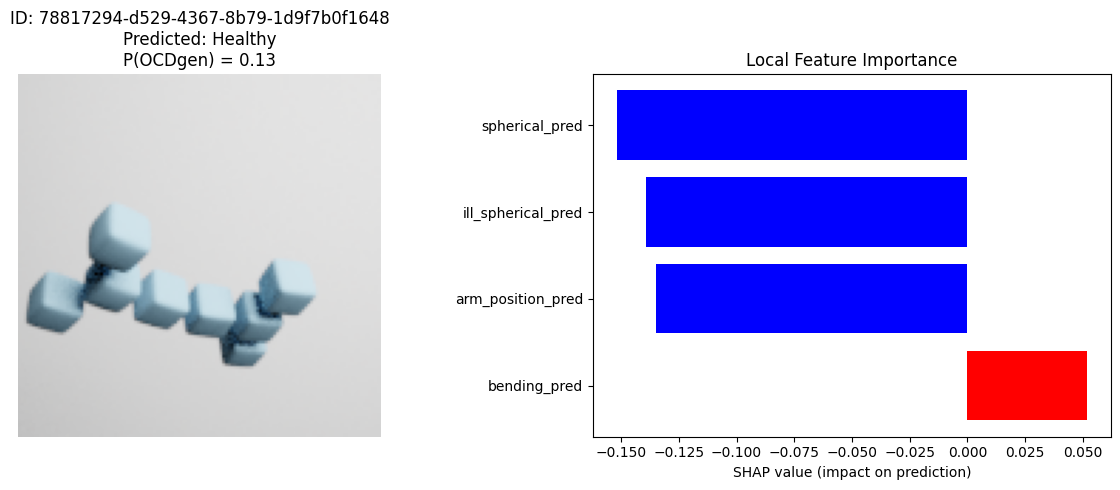

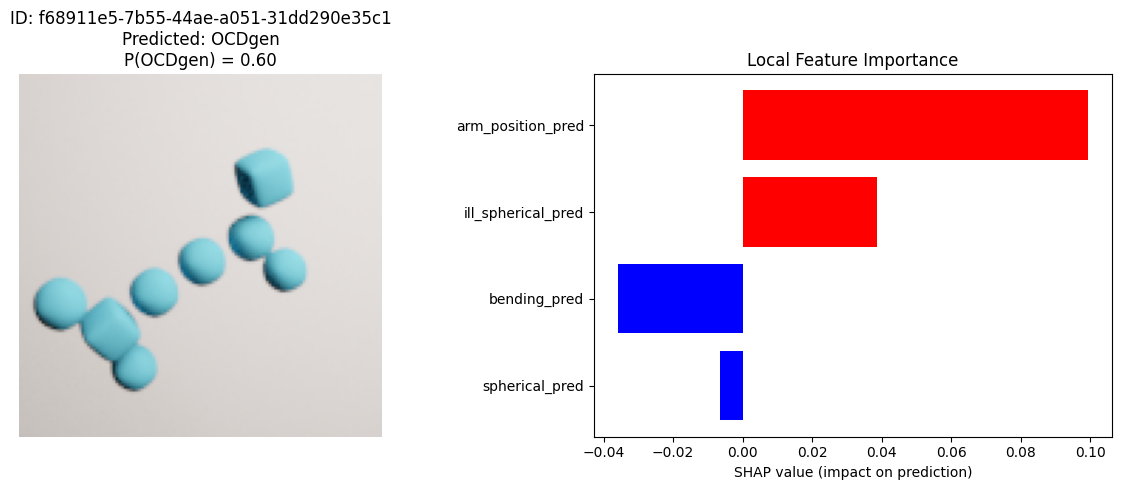

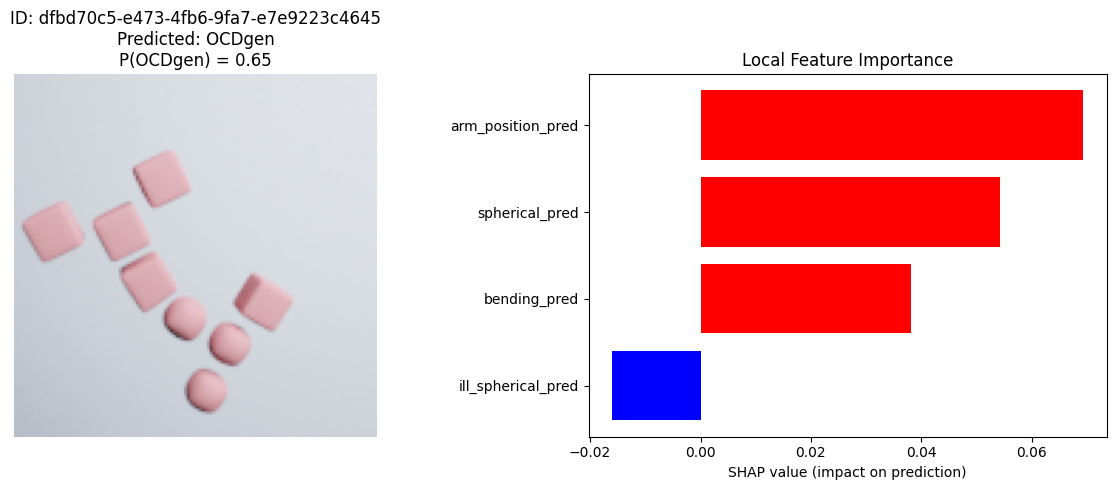

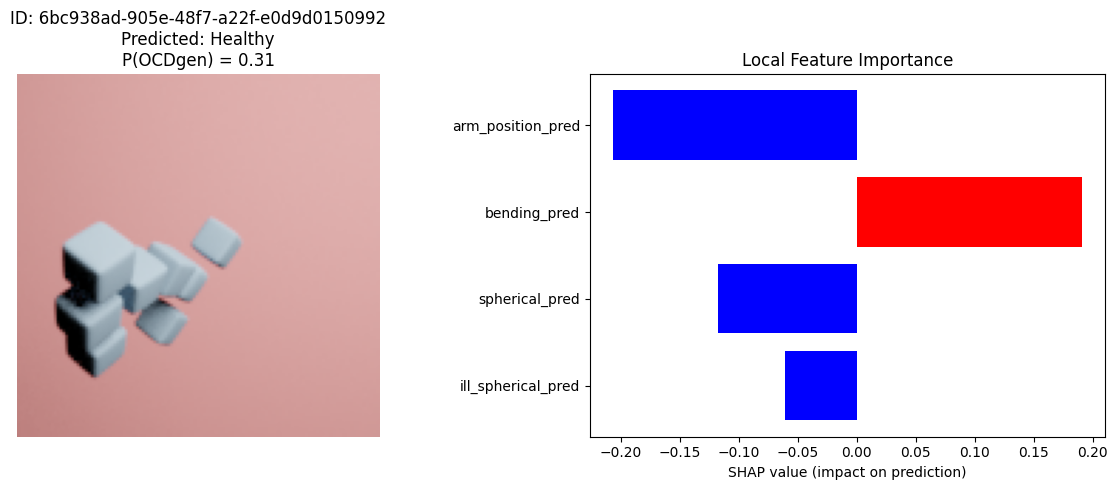

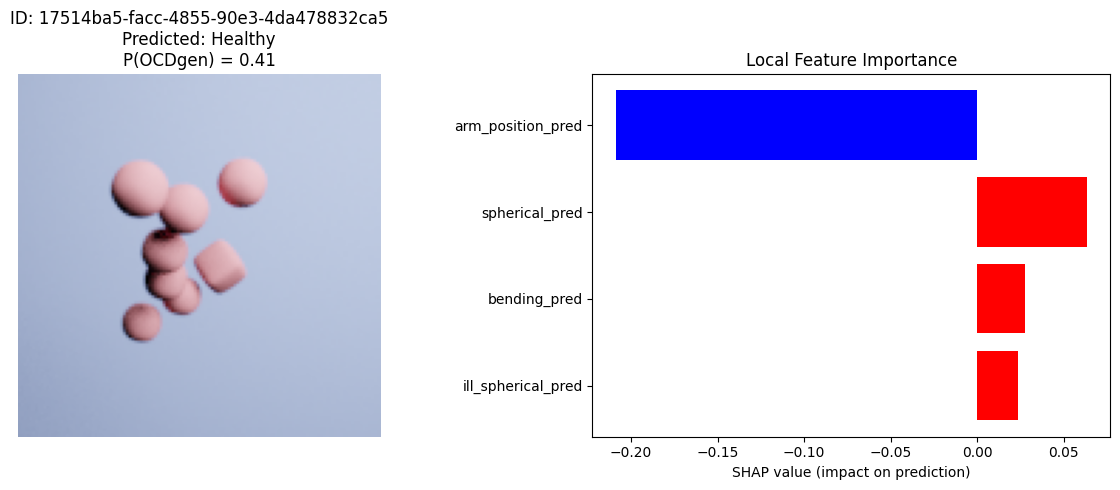

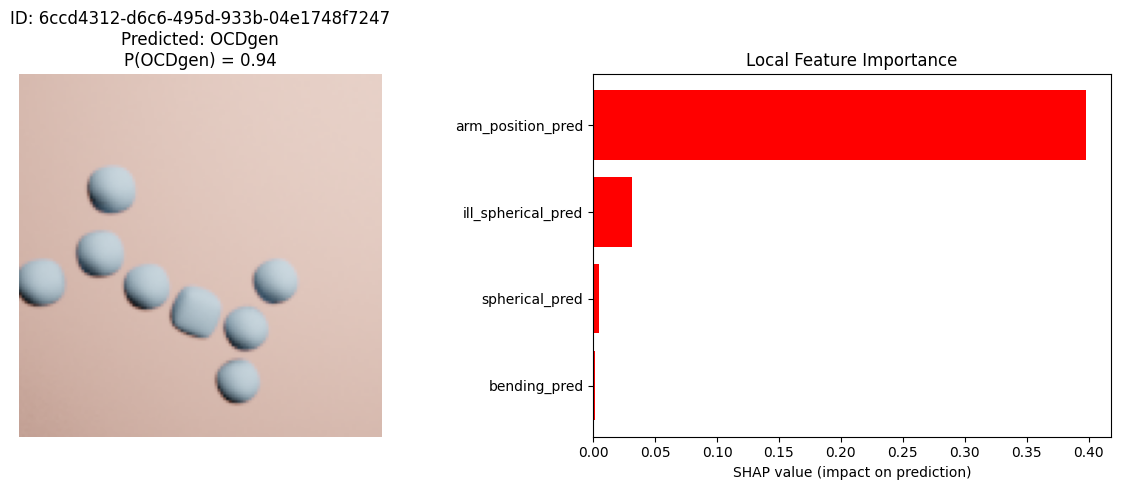

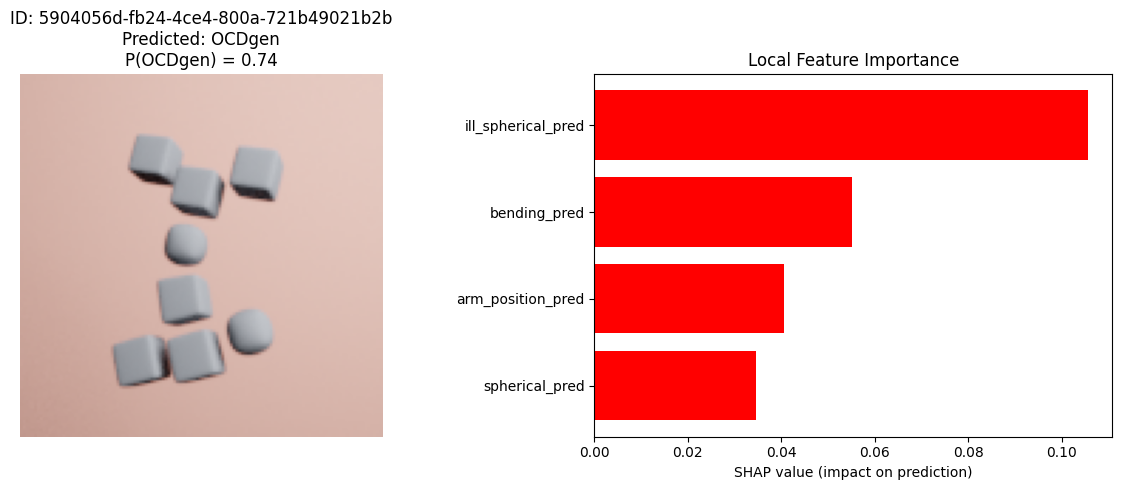

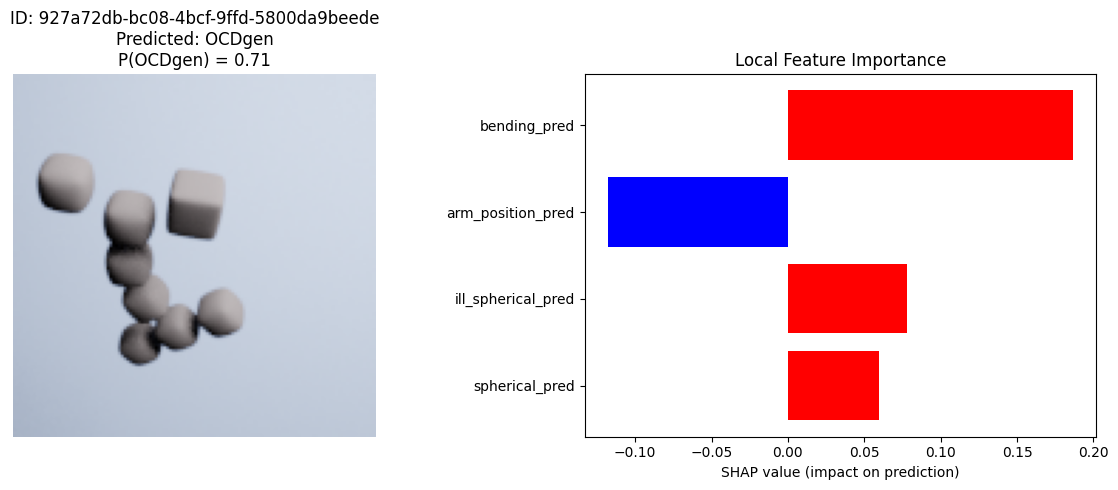

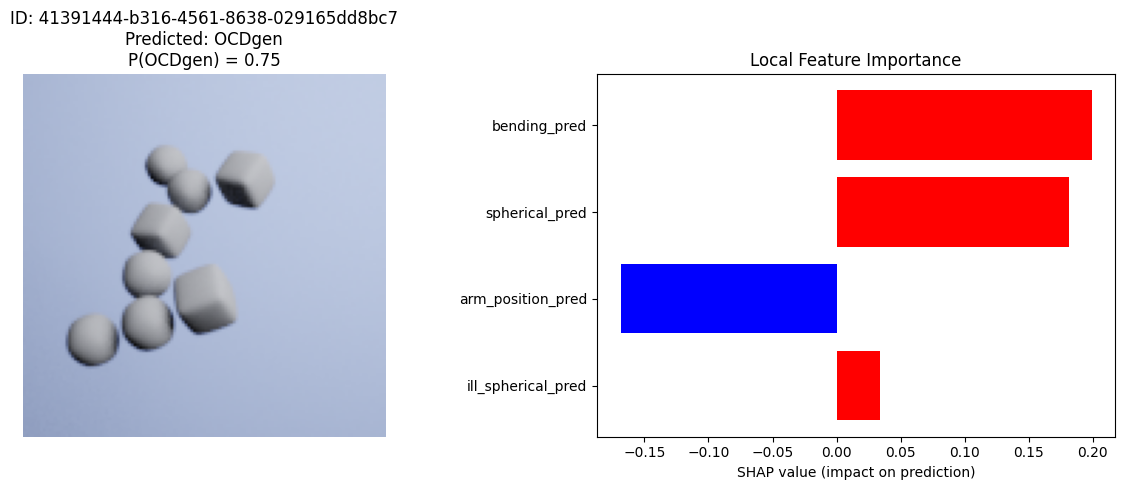

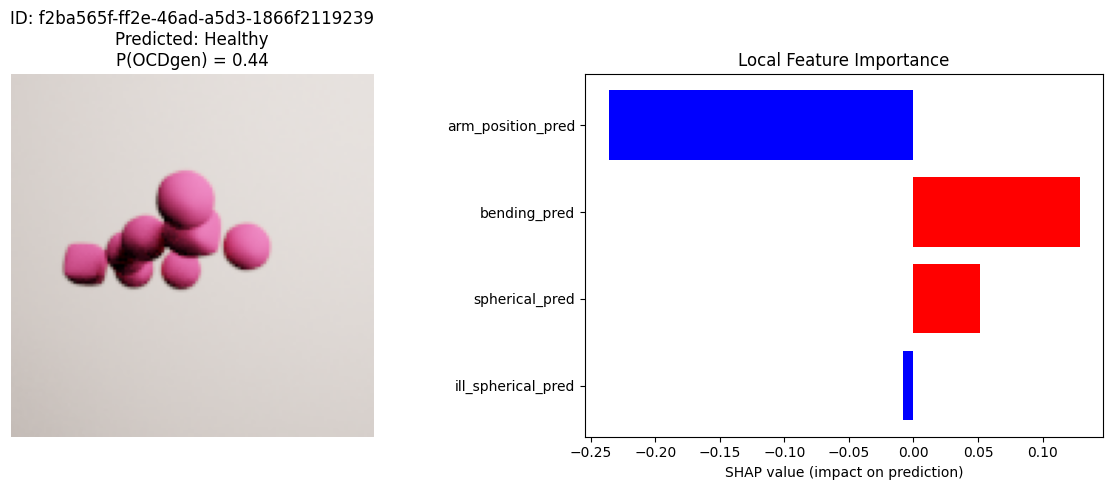

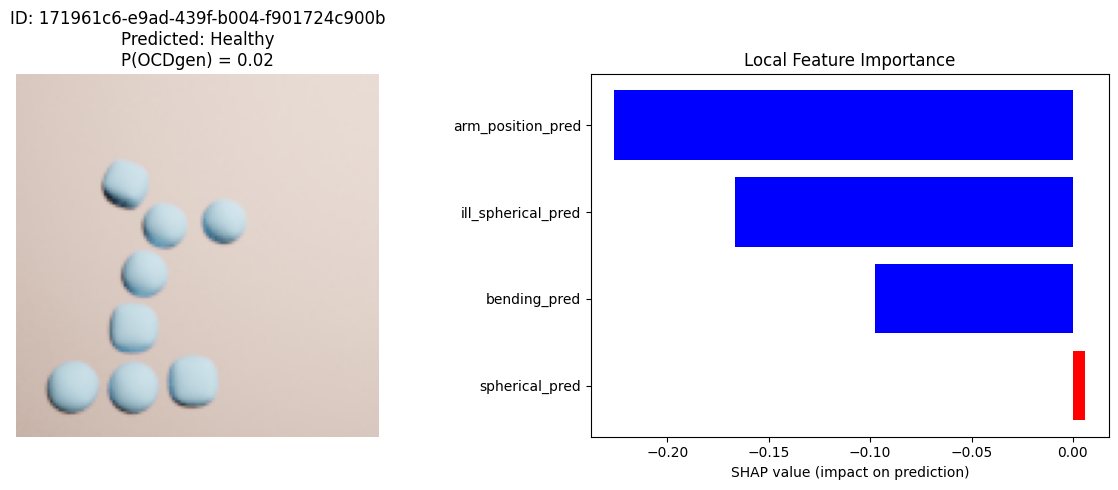

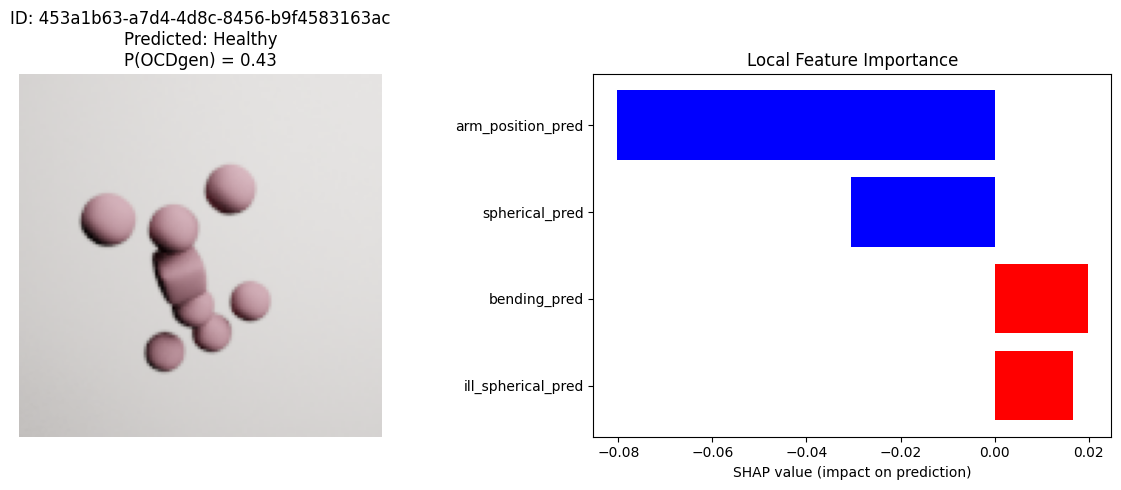

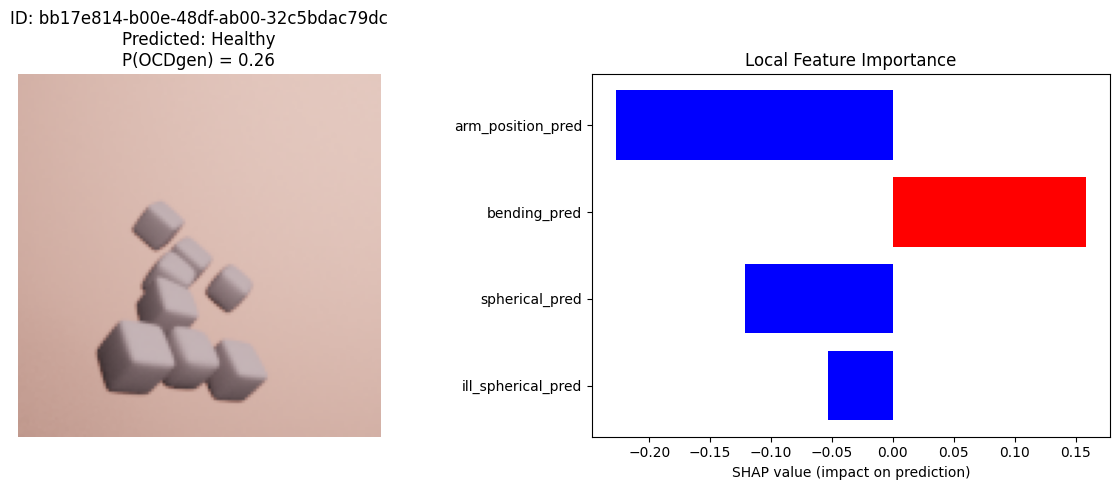

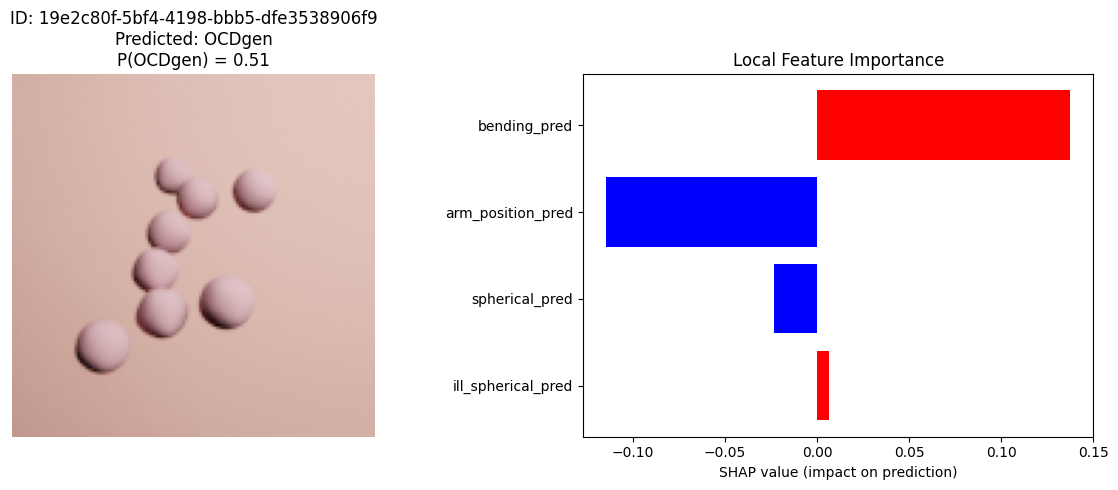

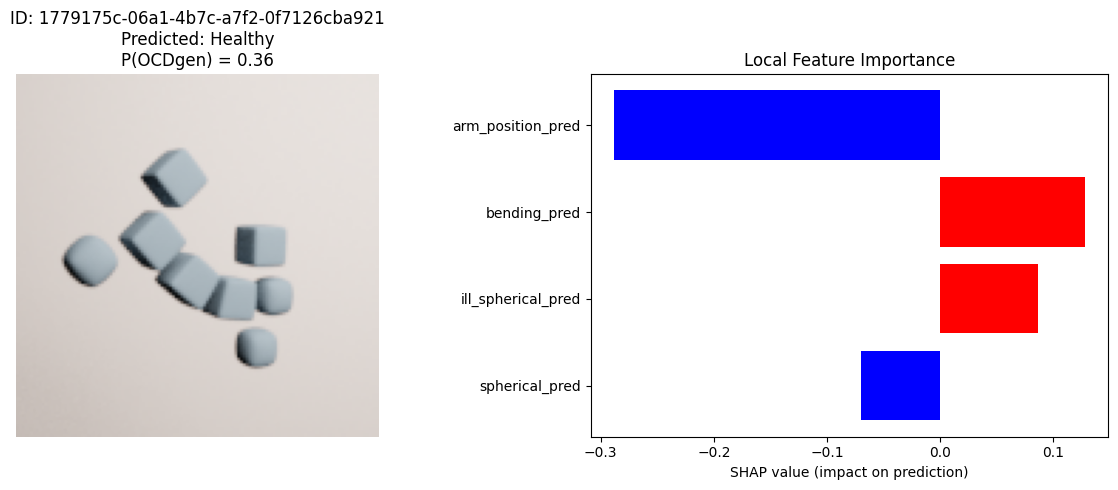

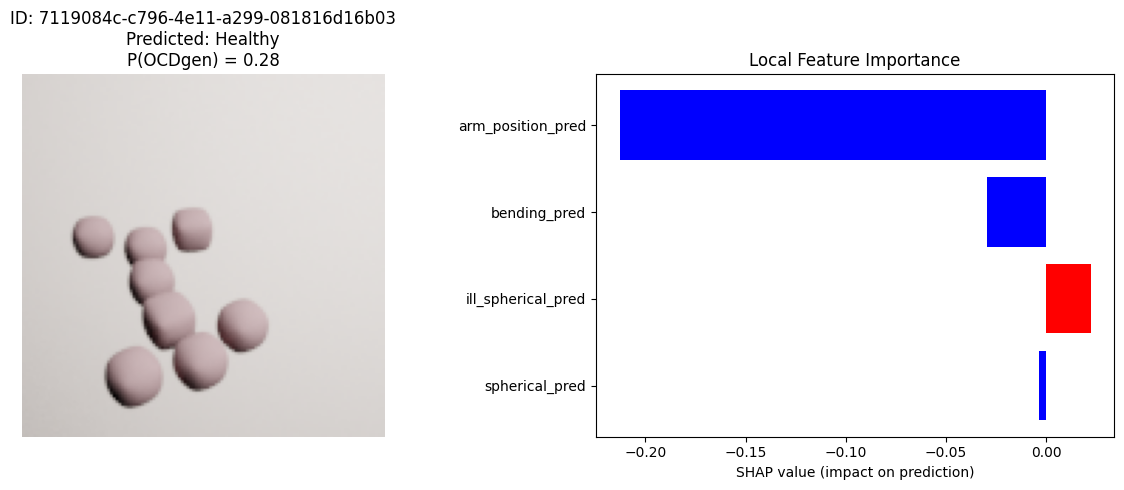

In [23]:
image_dir = Path("/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_variation/test")
for idx, row in df_sample.iterrows():
    # Load image
    sample_id = row["id"]
    sample_image_path = image_dir / f"{sample_id}.png"
    sample_image = Image.open(sample_image_path).convert("RGB")


    # Extract SHAP values for this sample
    original_idx = df_variation_test_merged.index[df_variation_test_merged['id'] == sample_id].tolist()[0]

    sample_features = X_test_new[original_idx, :]
    sample_shap = shap_values[original_idx, :, 1]

    # Model prediction & probability
    pred_proba = rf.predict_proba(sample_features.reshape(1, -1))[0]
    pred_label = "OCDgen" if np.argmax(pred_proba) == 1 else "Healthy"

    # Sort SHAP values for bar plot
    sorted_idx = np.argsort(np.abs(sample_shap))[::-1]
    sorted_features = [feature_names[j] for j in sorted_idx]
    sorted_values = sample_shap[sorted_idx]
    sorted_feature_values = sample_features[sorted_idx]

    # Plot image + SHAP bar plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Left panel: Image
    ax[0].imshow(sample_image)
    ax[0].axis('off')
    ax[0].set_title(f"ID: {sample_id}\nPredicted: {pred_label}\nP(OCDgen) = {pred_proba[1]:.2f}")

    # Right panel: SHAP bar chart
    colors = ['red' if v > 0 else 'blue' for v in sorted_values]
    ax[1].barh(sorted_features, sorted_values, color=colors)
    ax[1].set_xlabel("SHAP value (impact on prediction)")
    ax[1].set_title("Local Feature Importance")
    ax[1].invert_yaxis()
    plt.tight_layout()
    plt.show()